# **OFA**
You can use different instructions to perform various tasks (i.e., image captioning, visual grounding, VQA and grounded captioning) with just one model.

In [ ]:
# clone OFA if there does not exist the repo
% cd /content
! git clone https://github.com/OFA-Sys/OFA.git

/content
fatal: destination path 'OFA' already exists and is not an empty directory.


## **Download Checkpoint**
We provide a link for our public checkpoint, and you only need to wget it to your workspace.

In [ ]:
% cd /content
! mkdir -p /content/OFA/checkpoints/
! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/ofa_large_384.pt
! mv ofa_large_384.pt OFA/checkpoints/ofa_large.pt

/content
--2022-05-27 12:11:29--  https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/ofa_large_384.pt
Resolving ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)... 47.88.111.45
Connecting to ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)|47.88.111.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6230622025 (5.8G) [application/octet-stream]
Saving to: ‘ofa_large_384.pt’

ofa_large_384.pt    100%[===================>]   5.80G  56.3MB/s    in 1m 58s  

2022-05-27 12:13:27 (50.3 MB/s) - ‘ofa_large_384.pt’ saved [6230622025/6230622025]



## **Install Fairseq**
We advise you to install fairseq by cloning the official repository and running "pip install". 

You should restart the window if you meet the hint of "RESTART RUNTIME". 

In [ ]:
# clone Fairseq for installation
% cd /content
! git clone https://github.com/pytorch/fairseq.git
% cd /content/fairseq
! pip install --use-feature=in-tree-build ./

/content
fatal: destination path 'fairseq' already exists and is not an empty directory.
/content/fairseq
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+e0884db-cp37-cp37m-linux_x86_64.whl size=15364774 sha256=6b1ca9e8cf0a0a4815c7672fb619a4c5c2efab42b6d62edd14a0a00a821a566c
  Stored in directory: /tmp/pip-ephem-wheel-cache-inn3bs14/wheels/7c/35/80/edbd520a1a7e615df007002aeea9f6bf5f3c8f9243e072f6ce
Successfully built fairseq
  Attempting uninstall: fairseq
    Found existing installation: fairseq 1.0.0a0+e0884db
    Uninstalling fairseq-1.0.0a0+e0884db:
      Successfully uninstalled fairseq-1.0.0a0+e0884db


## **Preparation**
Below you just need to import required packages, and check whether to use GPU or FP16. 

In [ ]:
% cd /content/OFA
! sed '1d' requirements.txt | xargs -I {} pip install {}

/content/OFA
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simpl

In [ ]:
import torch
import numpy as np
from fairseq import checkpoint_utils, distributed_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from tasks.mm_tasks.refcoco import RefcocoTask

from models.ofa import OFAModel
from PIL import Image

tasks.register_task('refcoco', RefcocoTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

# specify some options for evaluation
parser = options.get_generation_parser()
input_args = ["", "--task=refcoco", "--beam=10", "--path=checkpoints/ofa_large.pt", "--bpe-dir=utils/BPE", "--no-repeat-ngram-size=3", "--patch-image-size=384"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)

2022-05-27 12:15:01 | INFO | numexpr.utils | NumExpr defaulting to 2 threads.


## **Build Model**
Below you can build your model and load the weights from the given checkpoint, and also build a generator. 

In [ ]:
# Load pretrained ckpt & config
task = tasks.setup_task(cfg.task)
models, cfg = checkpoint_utils.load_model_ensemble(
    utils.split_paths(cfg.common_eval.path),
    task=task
)

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

2022-05-27 12:15:07 | INFO | tasks.ofa_task | source dictionary: 59457 types
2022-05-27 12:15:07 | INFO | tasks.ofa_task | target dictionary: 59457 types
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
task.cfg.patch_image_size

384

## **Preprocess**
We demonstrate the required transformation fucntions for preprocessing inputs.

In [ ]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((task.cfg.patch_image_size, task.cfg.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()


def get_symbols_to_strip_from_output(generator):
    if hasattr(generator, "symbols_to_strip_from_output"):
        return generator.symbols_to_strip_from_output
    else:
        return {generator.bos, generator.eos}


def decode_fn(x, tgt_dict, bpe, generator, tokenizer=None):
    x = tgt_dict.string(x.int().cpu(), extra_symbols_to_ignore=get_symbols_to_strip_from_output(generator))
    token_result = []
    bin_result = []
    img_result = []
    for token in x.strip().split():
      if token.startswith('<bin_'):
        bin_result.append(token)
      elif token.startswith('<code_'):
        img_result.append(token)
      else:
        if bpe is not None:
          token = bpe.decode('{}'.format(token))
        if tokenizer is not None:
          token = tokenizer.decode(token)
        if token.startswith(' ') or len(token_result) == 0:
          token_result.append(token.strip())
        else:
          token_result[-1] += token

    return ' '.join(token_result), ' '.join(bin_result), ' '.join(img_result)


def coord2bin(coords, w_resize_ratio, h_resize_ratio):
    coord_list = [float(coord) for coord in coords.strip().split()]
    bin_list = []
    bin_list += ["<bin_{}>".format(int(round(coord_list[0] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int(round(coord_list[1] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int(round(coord_list[2] * w_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    bin_list += ["<bin_{}>".format(int(round(coord_list[3] * h_resize_ratio / task.cfg.max_image_size * (task.cfg.num_bins - 1))))]
    return ' '.join(bin_list)


def bin2coord(bins, w_resize_ratio, h_resize_ratio):
    bin_list = [int(bin[5:-1]) for bin in bins.strip().split()]
    coord_list = []
    coord_list += [bin_list[0] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[1] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    coord_list += [bin_list[2] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / w_resize_ratio]
    coord_list += [bin_list[3] / (task.cfg.num_bins - 1) * task.cfg.max_image_size / h_resize_ratio]
    return coord_list


def encode_text(text, length=None, append_bos=False, append_eos=False):
    line = [
      task.bpe.encode(' {}'.format(word.strip())) 
      if not word.startswith('<code_') and not word.startswith('<bin_') else word
      for word in text.strip().split()
    ]
    line = ' '.join(line)
    s = task.tgt_dict.encode_line(
        line=line,
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

def construct_sample(image: Image, instruction: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    instruction = encode_text(' {}'.format(instruction.lower().strip()), append_bos=True, append_eos=True).unsqueeze(0)
    instruction_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in instruction])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": instruction,
            "src_lengths": instruction_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        }
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## **Run Inference** (Image Captioning)
Download an image and run the following scripts to generate results.

In [ ]:
# download image
! wget https://ofa-beijing.oss-cn-beijing.aliyuncs.com/datasets/show_case/test_grounded_qa.jpeg -O test.jpeg

# construct instruction
image = Image.open('./test.jpeg')
instruction = "what does the image describe?"

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)

# display result
display(image)
print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Score: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Score: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Score: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Score: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Score: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))

--2022-05-27 12:15:35--  https://ofa-beijing.oss-cn-beijing.aliyuncs.com/datasets/show_case/test_grounded_qa.jpeg
Resolving ofa-beijing.oss-cn-beijing.aliyuncs.com (ofa-beijing.oss-cn-beijing.aliyuncs.com)... 59.110.190.134
Connecting to ofa-beijing.oss-cn-beijing.aliyuncs.com (ofa-beijing.oss-cn-beijing.aliyuncs.com)|59.110.190.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82325 (80K) [image/jpeg]
Saving to: ‘test.jpeg’

test.jpeg           100%[===================>]  80.40K  93.6KB/s    in 0.9s    

2022-05-27 12:15:38 (93.6 KB/s) - ‘test.jpeg’ saved [82325/82325]



KeyboardInterrupt: ignored

## **Run Inference** (VQA)
Download an image and run the following scripts to generate results.

In [ ]:
# download image
! wget https://ofa-beijing.oss-cn-beijing.aliyuncs.com/datasets/show_case/test_grounded_qa.jpeg -O test.jpeg

# construct instruction
image = Image.open('./test.jpeg')
instruction = "what color is the left car?"

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)

# display result
display(image)
print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Score: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Score: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Score: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Score: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Score: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))

## **Run Inference** (Grounded QA)
Download an image and run the following scripts to generate results.

--2022-05-27 12:19:43--  https://ofa-beijing.oss-cn-beijing.aliyuncs.com/datasets/show_case/test_grounded_qa.jpeg
Resolving ofa-beijing.oss-cn-beijing.aliyuncs.com (ofa-beijing.oss-cn-beijing.aliyuncs.com)... 59.110.190.134
Connecting to ofa-beijing.oss-cn-beijing.aliyuncs.com (ofa-beijing.oss-cn-beijing.aliyuncs.com)|59.110.190.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82325 (80K) [image/jpeg]
Saving to: ‘test.jpeg’

test.jpeg           100%[===================>]  80.40K   151KB/s    in 0.5s    

2022-05-27 12:19:46 (151 KB/s) - ‘test.jpeg’ saved [82325/82325]



/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


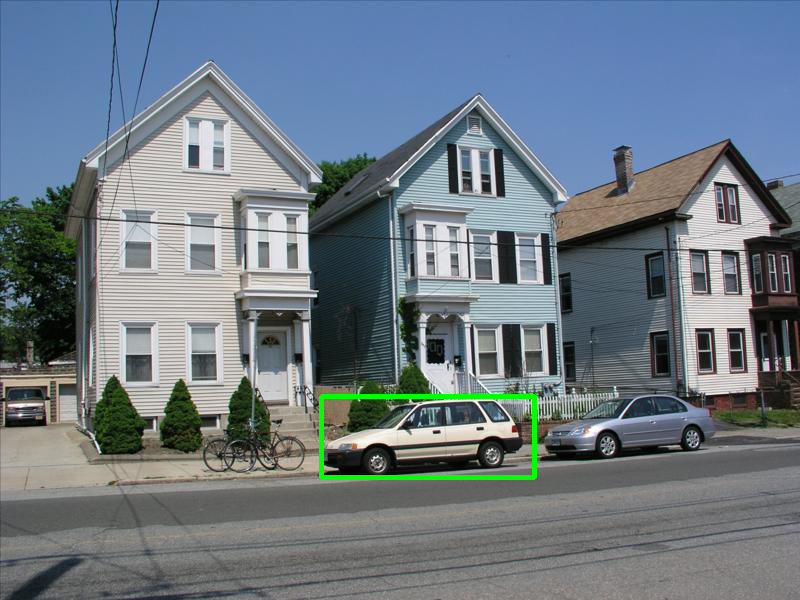

Instruction: what color is the car in the region? region: <bin_301> <bin_495> <bin_501> <bin_596>
OFA's Output1: tan, Score: 0.5766498446464539
OFA's Output2: brown, Score: 0.47536706924438477
OFA's Output3: gray, Score: 0.32187172770500183
OFA's Output4: white, Score: 0.27750974893569946
OFA's Output5: silver, Score: 0.2510034441947937


In [ ]:
import cv2
import numpy
from google.colab.patches import cv2_imshow

# download image
! wget https://ofa-beijing.oss-cn-beijing.aliyuncs.com/datasets/show_case/test_grounded_qa.jpeg -O test.jpeg

# construct instruction
image = Image.open('./test.jpeg')
w, h = image.size
w_resize_ratio = task.cfg.patch_image_size / w
h_resize_ratio = task.cfg.patch_image_size / h
coords = "321.0 396.0 535.0 477.0"
bins = coord2bin(coords, w_resize_ratio, h_resize_ratio)
instruction = "what color is the car in the region? region: " + bins

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)

# display result
img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
cv2.rectangle(
    img,
    (int(coord_list[0]), int(coord_list[1])),
    (int(coord_list[2]), int(coord_list[3])),
    (0, 255, 0),
    3
)
cv2_imshow(img)

print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Score: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Score: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Score: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Score: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Score: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


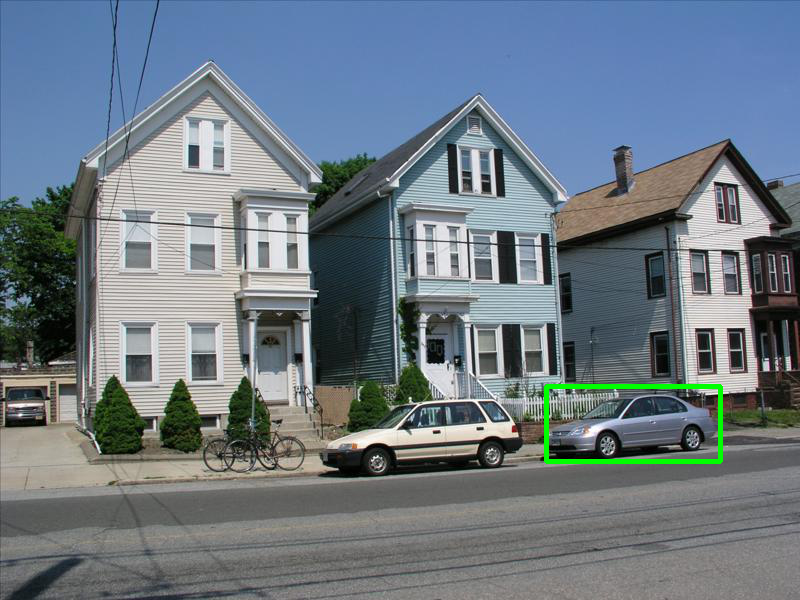

Instruction: what color is the car in the region? region: <bin_512> <bin_483> <bin_675> <bin_576>
OFA's Output1: gray, Probs: 0.42125532031059265
OFA's Output2: brown, Probs: 0.4202275574207306
OFA's Output3: tan, Probs: 0.38384735584259033
OFA's Output4: black, Probs: 0.30630549788475037
OFA's Output5: red, Probs: 0.3013334274291992


In [ ]:
coords = "547.0 387.0 721.0 461.0"
bins = coord2bin(coords, w_resize_ratio, h_resize_ratio)
instruction = "what color is the car in the region? region: " + bins

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)

# display result
img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
cv2.rectangle(
    img,
    (int(coord_list[0]), int(coord_list[1])),
    (int(coord_list[2]), int(coord_list[3])),
    (0, 255, 0),
    3
)
cv2_imshow(img)

print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Probs: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Probs: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Probs: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Probs: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Probs: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


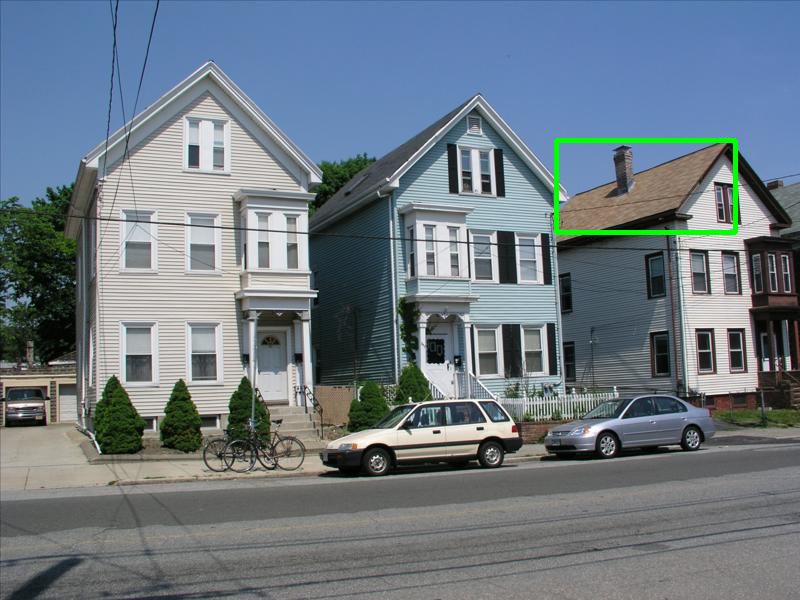

Instruction: what color is the roof in the region? region: <bin_521> <bin_176> <bin_689> <bin_290>
OFA's Output1: brown, Probs: 0.9285243153572083
OFA's Output2: light brown, Probs: 0.22152966260910034
OFA's Output3: tan, Probs: 0.19114495813846588
OFA's Output4: red, Probs: 0.1568044275045395
OFA's Output5: gray, Probs: 0.13805148005485535


In [ ]:
coords = "556.0 141.0 736.0 232.0"
bins = coord2bin(coords, w_resize_ratio, h_resize_ratio)
instruction = "what color is the roof in the region? region: " + bins

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)

# display result
img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
cv2.rectangle(
    img,
    (int(coord_list[0]), int(coord_list[1])),
    (int(coord_list[2]), int(coord_list[3])),
    (0, 255, 0),
    3
)
cv2_imshow(img)

print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Probs: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Probs: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Probs: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Probs: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Probs: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


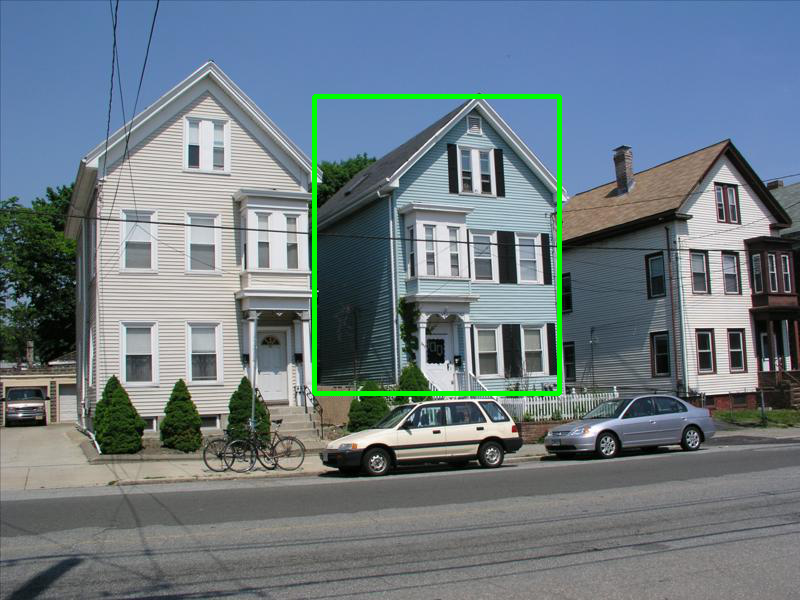

Instruction: what color is the house in the region? region: <bin_295> <bin_120> <bin_524> <bin_491>
OFA's Output1: light blue, Probs: 0.5336431860923767
OFA's Output2: blue, Probs: 0.44386252760887146
OFA's Output3: white, Probs: 0.44045576453208923
OFA's Output4: gray, Probs: 0.365533709526062
OFA's Output5: brown, Probs: 0.32233595848083496


In [ ]:
coords = "315.0 96.0 559.0 393.0"
bins = coord2bin(coords, w_resize_ratio, h_resize_ratio)
instruction = "what color is the house in the region? region: " + bins

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)

# display result
img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
cv2.rectangle(
    img,
    (int(coord_list[0]), int(coord_list[1])),
    (int(coord_list[2]), int(coord_list[3])),
    (0, 255, 0),
    3
)
cv2_imshow(img)

print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Probs: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Probs: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Probs: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Probs: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Probs: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


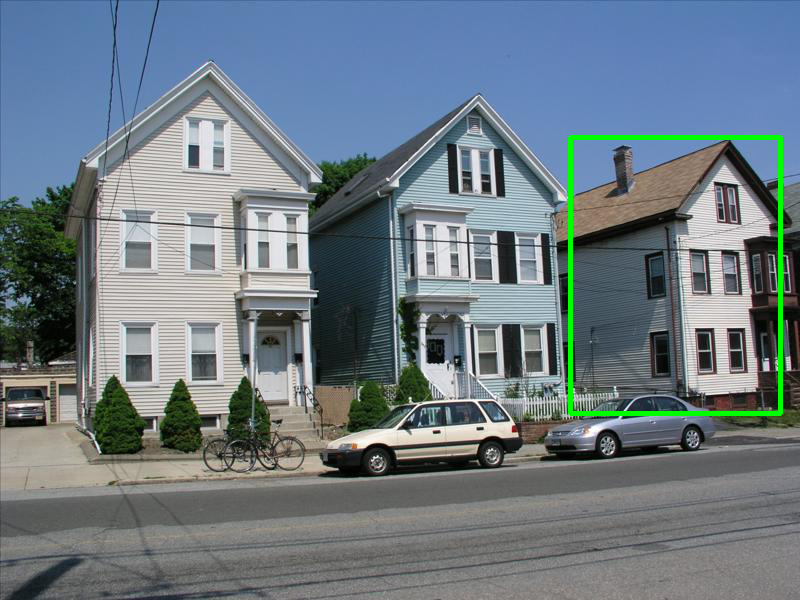

Instruction: what color is the house in the region? region: <bin_534> <bin_172> <bin_731> <bin_516>
OFA's Output1: white, Probs: 0.49109023809432983
OFA's Output2: light blue, Probs: 0.4817827641963959
OFA's Output3: blue, Probs: 0.4146095812320709
OFA's Output4: brown, Probs: 0.3788844048976898
OFA's Output5: gray, Probs: 0.30369821190834045


In [ ]:
coords = "570.0 138.0 780.0 413.0"
bins = coord2bin(coords, w_resize_ratio, h_resize_ratio)
instruction = "what color is the house in the region? region: " + bins

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)

# display result
img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
cv2.rectangle(
    img,
    (int(coord_list[0]), int(coord_list[1])),
    (int(coord_list[2]), int(coord_list[3])),
    (0, 255, 0),
    3
)
cv2_imshow(img)

print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Probs: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Probs: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Probs: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Probs: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Probs: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


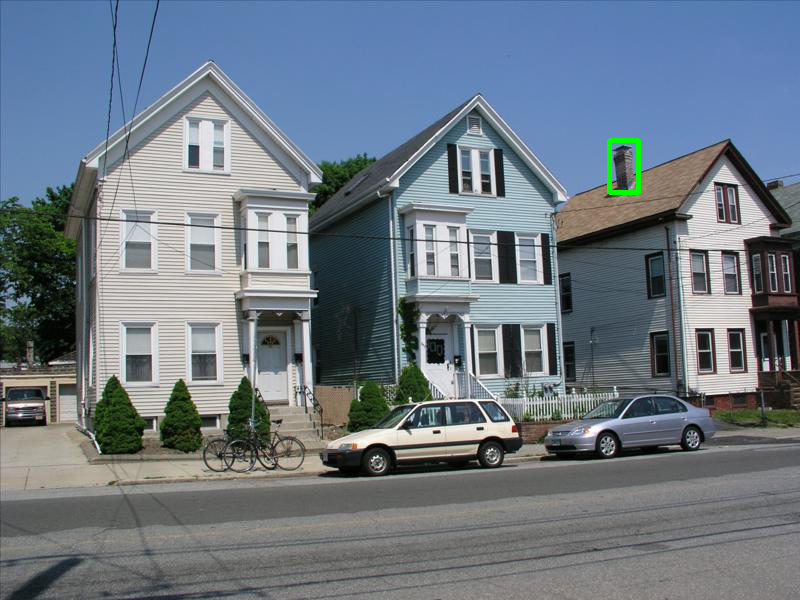

Instruction: what object is in the region? region: <bin_571> <bin_175> <bin_598> <bin_240>
OFA's Output1: chimney, Probs: 0.8309429883956909
OFA's Output2: window on the building, Probs: 0.6774371266365051
OFA's Output3: window of a house, Probs: 0.46958038210868835
OFA's Output4: window on the house, Probs: 0.43240422010421753
OFA's Output5: window, Probs: 0.24662122130393982


In [ ]:
coords = "610.0 140.0 639.0 192.0"
bins = coord2bin(coords, w_resize_ratio, h_resize_ratio)
instruction = "what object is in the region? region: " + bins

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens1, bins1, imgs1 = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens2, bins2, imgs2 = decode_fn(hypos[0][1]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens3, bins3, imgs3 = decode_fn(hypos[0][2]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens4, bins4, imgs4 = decode_fn(hypos[0][3]["tokens"], task.tgt_dict, task.bpe, generator)
    tokens5, bins5, imgs5 = decode_fn(hypos[0][4]["tokens"], task.tgt_dict, task.bpe, generator)

# display result
img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
cv2.rectangle(
    img,
    (int(coord_list[0]), int(coord_list[1])),
    (int(coord_list[2]), int(coord_list[3])),
    (0, 255, 0),
    3
)
cv2_imshow(img)

print('Instruction: {}'.format(instruction))
print('OFA\'s Output1: {}, Probs: {}'.format(tokens1, hypos[0][0]["score"].exp().item()))
print('OFA\'s Output2: {}, Probs: {}'.format(tokens2, hypos[0][1]["score"].exp().item()))
print('OFA\'s Output3: {}, Probs: {}'.format(tokens3, hypos[0][2]["score"].exp().item()))
print('OFA\'s Output4: {}, Probs: {}'.format(tokens4, hypos[0][3]["score"].exp().item()))
print('OFA\'s Output5: {}, Probs: {}'.format(tokens5, hypos[0][4]["score"].exp().item()))

## **Run Inference** (Visual Grounding)
Download an image and run the following scripts to generate results.

In [ ]:
import cv2
import numpy
from google.colab.patches import cv2_imshow

# download image
! wget https://ofa-beijing.oss-cn-beijing.aliyuncs.com/datasets/show_case/test_grounded_qa.jpeg -O test.jpeg

# construct instruction
image = Image.open('./test.jpeg')
instruction = 'which region does the text " a grey car " describe?'

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, instruction)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

# Generate result
with torch.no_grad():
    hypos = task.inference_step(generator, models, sample)
    tokens, bins, imgs = decode_fn(hypos[0][0]["tokens"], task.tgt_dict, task.bpe, generator)

# display result
w_resize_ratio = task.cfg.patch_image_size / w
h_resize_ratio = task.cfg.patch_image_size / h
img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
coord_list = bin2coord(bins, w_resize_ratio, h_resize_ratio)
cv2.rectangle(
    img,
    (int(coord_list[0]), int(coord_list[1])),
    (int(coord_list[2]), int(coord_list[3])),
    (0, 255, 0),
    3
)
cv2_imshow(img)